# Final report - Data preprocessing
## 0. Load Data
We select the category **Cell Phones and Accessories** as our target data, including reviews data and metadata of items. Among available datasets we focus on two of them, **5-core** and **metadata**. **5-core** is a subset of the complete reviews data in which all users and items have at least 5 reviews. And **metadata** is the complete information dataset of items. Our main goal is to utilize the information of reviews, items and users if any, to establish a recommender system, which is expected to make appropriate recommendation for users.

First, we define some functions to load these two datasets.

In [4]:
import json
import numpy as np
import pandas as pd
import gzip
rng = np.random.RandomState(666)


def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)


def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [5]:
print('Loading reviews data...')
Reviews_df = getDF('./project/data/cell_phone.json.gz')
print('Loading meta data...')
Meta_df = getDF('./project/data/meta_Cell_Phones_and_Accessories.json.gz')
print('Loading other data...')
sentiment = pd.read_csv('./project/review_sentiment.csv')
info = pd.read_csv('./project/reviewer_info.csv')

Loading reviews data...
Loading meta data...
Loading other data...


## 1. Review dataset: **5-core**
The review dataset contains 1128437 reviews from 157212 users to 48186 items. Each review is recorded corresponding to 12 features, including the overall rating, review text, review images and so on. We select six of them, `asin`, `reviewID`, `overall`, `verified`, `reviewText` and `summary`.
- `asin`: item ID
- `reviewer ID`: user ID
- `overall`: rating
- `verified`: if the user is verified or not
- `reviewText`: review text
- `summary`: summary of review text
Among the above, `overall` is our target. `verified` is a binary variable about users. `reviewText` and `summary` will be used as text input.

In [6]:
print(f'There are {len(Reviews_df)} reviews.')
print(f'There are {len(Reviews_df.asin.unique())} items.')
print(f'There are {len(Reviews_df.reviewerID.unique())} users.')
print(Reviews_df.shape)
Reviews_df.head()

There are 1128437 reviews.
There are 48186 items.
There are 157212 users.
(1128437, 12)


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"08 4, 2014",A24E3SXTC62LJI,7508492919,{'Color:': ' Bling'},Claudia Valdivia,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,1407110400,NaN,NaN
1,5.0,True,"02 12, 2014",A269FLZCB4GIPV,7508492919,NaN,sarah ponce,When you don't want to spend a whole lot of ca...,1,1392163200,NaN,NaN
2,3.0,True,"02 8, 2014",AB6CHQWHZW4TV,7508492919,NaN,Kai,"so the case came on time, i love the design. I...",Its okay,1391817600,NaN,NaN
3,2.0,True,"02 4, 2014",A1M117A53LEI8,7508492919,NaN,Sharon Williams,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE,1391472000,NaN,NaN
4,4.0,True,"02 3, 2014",A272DUT8M88ZS8,7508492919,NaN,Bella Rodriguez,"I liked it because it was cute, but the studs ...",Cute!,1391385600,NaN,NaN


In [7]:
import warnings
warnings.filterwarnings('ignore')
cols = ['asin', 'reviewerID', 'overall','verified', 'reviewText', 'summary']
Reviews_DF = Reviews_df[cols]
Reviews_DF['verified'] = [int(v) for v in Reviews_df.verified]
print(Reviews_DF.shape)
Reviews_DF.head()

(1128437, 6)


,asin,reviewerID,overall,verified,reviewText,summary
0,7508492919,A24E3SXTC62LJI,5.0,1,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it
1,7508492919,A269FLZCB4GIPV,5.0,1,When you don't want to spend a whole lot of ca...,1
2,7508492919,AB6CHQWHZW4TV,3.0,1,"so the case came on time, i love the design. I...",Its okay
3,7508492919,A1M117A53LEI8,2.0,1,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE
4,7508492919,A272DUT8M88ZS8,4.0,1,"I liked it because it was cute, but the studs ...",Cute!


## 2. Item dataset: **metadata**
The item dataset contains 589356 items. Each item is recorded corresponding to 19 features, including title, main category, images and so on. We select seven of them, `asin`, `main_cat`, `description`, `title`, `feature`, `price` and image.
- `asin`: item ID
- `main_cat`: main category of the item (categorical)
- `description`: description of the item (text)
- `title`: title of the item (text)
- `feature`: feature of the item (text)
- `price`: price of the item (categorical)
- image: image of the item (image)

Among the above, `main_cat` and `price` are categorical variables. Here we binarize the price for there are many items not labeled price (more than half), so if there is a price this variable is set to 1 otherwise 0. For `main_cat`, there are 29 main categories, covering office products, car electronics, home supplies, etc.
`description`, `title` and `feature` are all text and remain to be processed to a standard format in the following.

In [8]:
print(f'There are {len(Meta_df.asin.unique())} items in metadata.')
Items_df = pd.DataFrame({'asin': Reviews_df.asin.unique()})
Items_DF = pd.merge(Items_df, Meta_df, on='asin', how='inner')
print(f'There are {len(Items_DF)} items in 5-core dataset.')
Items_DF.head()

There are 589356 items in metadata.
There are 48210 items in 5-core dataset.


,asin,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,imageURL,imageURLHighRes
0,7508492919,"[Cell Phones & Accessories, Cases, Holsters & ...",,"[, Elegani Butterfly Case 3D Pattern Back Cove...",,MinisDesign 3d Bling Crystal Bow Transparent C...,[],,ELEGANI,[Fashionable with unique 3D butterfly design f...,"[>#228,544 in Cell Phones & Accessories (See T...",[],{},Cell Phones & Accessories,,,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,7532385086,"[Cell Phones & Accessories, Cases, Holsters & ...",,"[Product Description\nHTC EVO 4G, Rubberized P...",,Rubberized Purple Wave Flower Snap on Design C...,[],,Generic,[Rubberized Purple Wave Flower Snap on Design ...,"[>#553,803 in Cell Phones & Accessories (See T...",[],{},Cell Phones & Accessories,,,,[],[]
2,7887421268,"[Cell Phones & Accessories, Cases, Holsters & ...",,[Description:\nProtect your phone with style t...,,Black And Pink Leopard Rubberized Snap on Desi...,[],,Generic,[],"[>#440,155 in Cell Phones & Accessories (See T...",[],{},Cell Phones & Accessories,,,$5.95,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
3,8288853439,"[Cell Phones & Accessories, Accessories, Charg...",,[Samsung Official OEM Travel Wall Charger for ...,,Samsung Official OEM Travel Wall Charger for y...,[],,BlackBerry,[Safely charge your phone from your car using ...,"[>#494,589 in Cell Phones & Accessories (See T...",[],{},Cell Phones & Accessories,,,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,8288862993,"[Cell Phones & Accessories, Accessories, Charg...",,[],,Samsung New Version ECA-U11CBE Official OEM Ca...,[],,Samsung,[Safely charge your phone from your car using ...,"[>#337,417 in Cell Phones & Accessories (See T...",[],{},Cell Phones & Accessories,,,$14.99,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


Here we delete the items without images.

In [9]:
haveimg = [len(img) > 0 for img in Items_DF.imageURL]
print(f'There are {sum(haveimg)} items with images.')
Items_DF = Items_DF.iloc[np.where(haveimg)[0]]
Items_DF.shape

There are 42726 items with images.


(42726, 19)

In [10]:
cols = list(Items_DF)
cols.remove('category')
cols.remove('tech1')
cols.remove('fit')
cols.remove('also_buy')
cols.remove('tech2')
cols.remove('brand')
cols.remove('rank')
cols.remove('also_view')
cols.remove('details')
cols.remove('similar_item')
cols.remove('date')
cols.remove('imageURL')
cols.remove('imageURLHighRes')

In [11]:
Items_DF = Items_DF[cols]
print(Items_DF.shape)
Items_DF.head()

(42726, 6)


,asin,description,title,feature,main_cat,price
0,7508492919,"[, Elegani Butterfly Case 3D Pattern Back Cove...",MinisDesign 3d Bling Crystal Bow Transparent C...,[Fashionable with unique 3D butterfly design f...,Cell Phones & Accessories,
2,7887421268,[Description:\nProtect your phone with style t...,Black And Pink Leopard Rubberized Snap on Desi...,[],Cell Phones & Accessories,$5.95
3,8288853439,[Samsung Official OEM Travel Wall Charger for ...,Samsung Official OEM Travel Wall Charger for y...,[Safely charge your phone from your car using ...,Cell Phones & Accessories,
4,8288862993,[],Samsung New Version ECA-U11CBE Official OEM Ca...,[Safely charge your phone from your car using ...,Cell Phones & Accessories,$14.99
8,9578085451,[HTC Evo 4G LTE (Sprint) White Flowers Design ...,HTC Evo 4G LTE (Sprint) White Flowers Design S...,[],Cell Phones & Accessories,


### 2.1 main_cat

In [12]:
print(f'There are {len(Items_DF.main_cat.unique())} main categories.')

There are 29 main categories.


### 2.2 description

In [13]:
d_new = []
for d in Items_DF['description']:
    for i in range(len(d)-1, -1, -1):
        d.remove('') if d[i] == '' else 0
    d_new.append(d)
descriptions = [' '.join(d) for d in d_new]
Items_DF['description'] = descriptions
Items_DF.head()

,asin,description,title,feature,main_cat,price
0,7508492919,Elegani Butterfly Case 3D Pattern Back Cover C...,MinisDesign 3d Bling Crystal Bow Transparent C...,[Fashionable with unique 3D butterfly design f...,Cell Phones & Accessories,
2,7887421268,Description:\nProtect your phone with style th...,Black And Pink Leopard Rubberized Snap on Desi...,[],Cell Phones & Accessories,$5.95
3,8288853439,Samsung Official OEM Travel Wall Charger for y...,Samsung Official OEM Travel Wall Charger for y...,[Safely charge your phone from your car using ...,Cell Phones & Accessories,
4,8288862993,,Samsung New Version ECA-U11CBE Official OEM Ca...,[Safely charge your phone from your car using ...,Cell Phones & Accessories,$14.99
8,9578085451,HTC Evo 4G LTE (Sprint) White Flowers Design S...,HTC Evo 4G LTE (Sprint) White Flowers Design S...,[],Cell Phones & Accessories,


### 2.3 title
All items have a title.

In [14]:
num = sum([t == '' for t in Items_DF.title])
print(f'There are {len(Items_DF) - num} items with title.')

There are 42726 items with title.


### 2.4 feature

In [15]:
num = sum([t == [] for t in Items_DF.feature])
print(f'There are {len(Items_DF) - num} items with feature.')
feature_list = [' '.join(f) for f in Items_DF.feature]
Items_DF['feature'] = feature_list
Items_DF.head()

There are 35989 items with feature.


,asin,description,title,feature,main_cat,price
0,7508492919,Elegani Butterfly Case 3D Pattern Back Cover C...,MinisDesign 3d Bling Crystal Bow Transparent C...,Fashionable with unique 3D butterfly design fo...,Cell Phones & Accessories,
2,7887421268,Description:\nProtect your phone with style th...,Black And Pink Leopard Rubberized Snap on Desi...,,Cell Phones & Accessories,$5.95
3,8288853439,Samsung Official OEM Travel Wall Charger for y...,Samsung Official OEM Travel Wall Charger for y...,Safely charge your phone from your car using t...,Cell Phones & Accessories,
4,8288862993,,Samsung New Version ECA-U11CBE Official OEM Ca...,Safely charge your phone from your car using t...,Cell Phones & Accessories,$14.99
8,9578085451,HTC Evo 4G LTE (Sprint) White Flowers Design S...,HTC Evo 4G LTE (Sprint) White Flowers Design S...,,Cell Phones & Accessories,


### 2.5 price

In [16]:
num = sum([p == '' for p in Items_DF.price])
print(f'There are {len(Items_DF) - num} items with price.')

There are 17210 items with price.


In [17]:
have_price = [0 if price == '' else 1 for price in Items_DF.price]
Items_DF['price'] = have_price
Items_DF.head()

,asin,description,title,feature,main_cat,price
0,7508492919,Elegani Butterfly Case 3D Pattern Back Cover C...,MinisDesign 3d Bling Crystal Bow Transparent C...,Fashionable with unique 3D butterfly design fo...,Cell Phones & Accessories,0
2,7887421268,Description:\nProtect your phone with style th...,Black And Pink Leopard Rubberized Snap on Desi...,,Cell Phones & Accessories,1
3,8288853439,Samsung Official OEM Travel Wall Charger for y...,Samsung Official OEM Travel Wall Charger for y...,Safely charge your phone from your car using t...,Cell Phones & Accessories,0
4,8288862993,,Samsung New Version ECA-U11CBE Official OEM Ca...,Safely charge your phone from your car using t...,Cell Phones & Accessories,1
8,9578085451,HTC Evo 4G LTE (Sprint) White Flowers Design S...,HTC Evo 4G LTE (Sprint) White Flowers Design S...,,Cell Phones & Accessories,0


In [18]:
img_col = [asin + '.jpg' for asin in Items_DF.asin]
cols = list(Items_DF)
Items_DF['img_col'] = img_col
cols.insert(0, 'img_col')
Items_DF = Items_DF[cols]
Items_DF.head()

,img_col,asin,description,title,feature,main_cat,price
0,7508492919.jpg,7508492919,Elegani Butterfly Case 3D Pattern Back Cover C...,MinisDesign 3d Bling Crystal Bow Transparent C...,Fashionable with unique 3D butterfly design fo...,Cell Phones & Accessories,0
2,7887421268.jpg,7887421268,Description:\nProtect your phone with style th...,Black And Pink Leopard Rubberized Snap on Desi...,,Cell Phones & Accessories,1
3,8288853439.jpg,8288853439,Samsung Official OEM Travel Wall Charger for y...,Samsung Official OEM Travel Wall Charger for y...,Safely charge your phone from your car using t...,Cell Phones & Accessories,0
4,8288862993.jpg,8288862993,,Samsung New Version ECA-U11CBE Official OEM Ca...,Safely charge your phone from your car using t...,Cell Phones & Accessories,1
8,9578085451.jpg,9578085451,HTC Evo 4G LTE (Sprint) White Flowers Design S...,HTC Evo 4G LTE (Sprint) White Flowers Design S...,,Cell Phones & Accessories,0


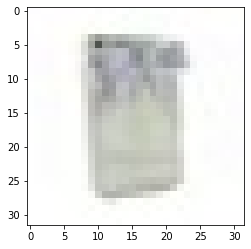

In [29]:
import os
import cv2
import matplotlib.pyplot as plt
image = cv2.imread(os.path.join('./project/data/Images for use', Items_DF.img_col[0]))
_ = plt.imshow(image)

## 3. Reviewer Information
In the original data, there is no specific dataset about users, while user information is also significant for a RecSys. Note that there exist records of users in the review data, therefore we extract some user information from it, including average score, average sentiment, total amount of reviews and weighted score.
- average score: average value of all ratings from the user
- average sentiment: average value of all sentiments of the reviews from the user
- total amount of reviews: total amount of reviews from the user
- weighted score: average value of all ratings from the user, weighted by votes of reviews

We use these extracted features as user characteristics.

In [20]:
print(f'There are {len(info)} users.')
print(info.shape)
info.head()

There are 157195 users.
(157195, 5)


,reviewerID,avg_score_u,avg_sentiment_u,tot_review_u,weighted_score_u
0,A0009478CBXKUCALUC7U,4.333333,0.666667,6,4.333333
1,A0024936S1WI02OHH9DP,5.000000,1.000000,5,5.000000
2,A0034986DWR7WEDQN0GV,4.818182,0.909091,11,4.818182
3,A0052224HSIECFUBVN5W,5.000000,0.800000,5,5.000000
4,A007917716EGEEP4D8LB,4.181818,0.363636,11,5.000000


In [21]:
info['tot_review_u>10'] = [1 if t > 10 else 0 for  t in info.tot_review_u]
info.head()

,reviewerID,avg_score_u,avg_sentiment_u,tot_review_u,weighted_score_u,tot_review_u>10
0,A0009478CBXKUCALUC7U,4.333333,0.666667,6,4.333333,0
1,A0024936S1WI02OHH9DP,5.000000,1.000000,5,5.000000,0
2,A0034986DWR7WEDQN0GV,4.818182,0.909091,11,4.818182,1
3,A0052224HSIECFUBVN5W,5.000000,0.800000,5,5.000000,0
4,A007917716EGEEP4D8LB,4.181818,0.363636,11,5.000000,1


## 4. Sentiment
Similar to reviewer information, beyond the above features, we extract additional item information from the review dataset, including average score, average sentiment, total amount of reviews and weighted score.
- average score: average value of all ratings of the item
- average sentiment: average value of all sentiments of the reviews of the item
- total amount of reviews: total amount of reviews item
- weighted score: average value of all ratings of the item, weighted by votes of reviews

In [22]:
print(sentiment.shape)
sentiment.head()

(48186, 5)


,asin,avg_score,avg_sentiment,tot_review,weighted_score
0,7508492919,4.136364,0.696970,66,5.000
1,7532385086,3.357143,0.571429,14,1.000
2,7887421268,3.375000,0.500000,16,3.375
3,8199900164,4.000000,0.800000,5,4.000
4,8288853439,3.894737,0.631579,19,5.000


## 4. Merge
By merging the review dataset, item dataset and user dataset, we'll get a new dataset containing the joint information of reviews, items and users. The joint dataset contains about 1 million reviews with corresponding items' and users' features. And we'll use this dataset to establish the recommender system.

In [23]:
Items_DF = pd.merge(Items_DF, sentiment, on='asin', how='inner')
print(Items_DF.shape)
Items_DF.tail()

(42726, 11)


,img_col,asin,description,title,feature,main_cat,price,avg_score,avg_sentiment,tot_review,weighted_score
42721,B01GUY86W8.jpg,B01GUY86W8,<b>ALCLAP S7 Curved Screen Protector of Clear ...,ALCLAP Galaxy S7 Screen Protector (Clear),Perfectly curved to fit the S7 entire screen f...,Cell Phones & Accessories,0,4.285714,0.714286,7,4.285714
42722,B01H1RWZWA.jpg,B01H1RWZWA,,"iPhone 6S Plus Case, akimoom [Knight Series] H...",,Cell Phones & Accessories,0,4.400000,0.400000,5,4.000000
42723,B01H72UJZ4.jpg,B01H72UJZ4,,"Oneplus 3 Screen Protector, E LV Tempered Glas...",,Cell Phones & Accessories,0,2.400000,0.000000,5,2.000000
42724,B01H8AH2YG.jpg,B01H8AH2YG,<b>Nillkin Amazing H+ Pro Nanometer Anti-explo...,"Moto G4 Plus Screen Protector, Nillkin [H+ Pro...","Designed for Moto G4 Plus, premium Japan AGC g...",Cell Phones & Accessories,0,4.000000,0.800000,5,4.000000
42725,B01HE0RNYO.jpg,B01HE0RNYO,<b>Compatible with Apple iPhone 6 Plus and iPh...,TrendON Apple iPhone 6 Plus and 6S Plus Case [...,[Compatible with Apple iPhone 6 Plus and iPhon...,Cell Phones & Accessories,1,4.400000,1.000000,5,4.400000


In [24]:
Reviews_DF = pd.merge(Reviews_DF, info, on='reviewerID', how='inner')
print(Reviews_DF.shape)
Reviews_DF.head()

(1128308, 11)


,asin,reviewerID,overall,verified,reviewText,summary,avg_score_u,avg_sentiment_u,tot_review_u,weighted_score_u,tot_review_u>10
0,7508492919,A24E3SXTC62LJI,5.0,1,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,4.4,0.6,5,4.4,0
1,B00931S8CE,A24E3SXTC62LJI,4.0,1,Perfect for charging overnight or when I'm on ...,Worth the price,4.4,0.6,5,4.4,0
2,B009PUZ5H4,A24E3SXTC62LJI,5.0,1,Came in way earlier than expected which is alw...,Way better than I expected!,4.4,0.6,5,4.4,0
3,B00AQG3UGY,A24E3SXTC62LJI,3.0,1,Very cute and phone fits perfectly without a p...,Good for occasional use,4.4,0.6,5,4.4,0
4,B00PQPW6UQ,A24E3SXTC62LJI,5.0,1,I bought this case for my sixteen year old bro...,Great quality!,4.4,0.6,5,4.4,0


In [25]:
RatingswUI = pd.merge(Reviews_DF, Items_DF, on='asin', how='inner')
print(len(RatingswUI))
RatingswUI.head()

1021580


,asin,reviewerID,overall,verified,reviewText,summary,avg_score_u,avg_sentiment_u,tot_review_u,weighted_score_u,...,img_col,description,title,feature,main_cat,price,avg_score,avg_sentiment,tot_review,weighted_score
0,7508492919,A24E3SXTC62LJI,5.0,1,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,4.400000,0.600000,5,4.400000,...,7508492919.jpg,Elegani Butterfly Case 3D Pattern Back Cover C...,MinisDesign 3d Bling Crystal Bow Transparent C...,Fashionable with unique 3D butterfly design fo...,Cell Phones & Accessories,0,4.136364,0.69697,66,5.0
1,7508492919,A269FLZCB4GIPV,5.0,1,When you don't want to spend a whole lot of ca...,1,5.000000,1.000000,6,5.000000,...,7508492919.jpg,Elegani Butterfly Case 3D Pattern Back Cover C...,MinisDesign 3d Bling Crystal Bow Transparent C...,Fashionable with unique 3D butterfly design fo...,Cell Phones & Accessories,0,4.136364,0.69697,66,5.0
2,7508492919,AB6CHQWHZW4TV,3.0,1,"so the case came on time, i love the design. I...",Its okay,4.600000,0.600000,5,4.600000,...,7508492919.jpg,Elegani Butterfly Case 3D Pattern Back Cover C...,MinisDesign 3d Bling Crystal Bow Transparent C...,Fashionable with unique 3D butterfly design fo...,Cell Phones & Accessories,0,4.136364,0.69697,66,5.0
3,7508492919,A1M117A53LEI8,2.0,1,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE,3.647059,0.588235,17,3.647059,...,7508492919.jpg,Elegani Butterfly Case 3D Pattern Back Cover C...,MinisDesign 3d Bling Crystal Bow Transparent C...,Fashionable with unique 3D butterfly design fo...,Cell Phones & Accessories,0,4.136364,0.69697,66,5.0
4,7508492919,A272DUT8M88ZS8,4.0,1,"I liked it because it was cute, but the studs ...",Cute!,4.218750,0.718750,32,4.000000,...,7508492919.jpg,Elegani Butterfly Case 3D Pattern Back Cover C...,MinisDesign 3d Bling Crystal Bow Transparent C...,Fashionable with unique 3D butterfly design fo...,Cell Phones & Accessories,0,4.136364,0.69697,66,5.0


## Save

In [26]:
# RatingswUI.to_csv('./project/RatingswithUI.csv', index=False)